In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
import numpy as np
import json

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)
from models.modeling_encoders import AutoEncoder
from notebooks.eval_care_retrieval import load_model, load_data

In [2]:
from utils.video import read_frames_decord
from models.modeling_encoders import AutoEncoder

# Load base model
model_path = "/work/piyush/pretrained_checkpoints/Tarsier-7b"
device_map = "auto"
attn_implementation = 'flash_attention_2'
model_base = AutoEncoder.from_pretrained(model_path, device_map=device_map, attn_implementation=attn_implementation, use_flash_attn=False, dtype=torch.bfloat16)
su.misc.num_params(model_base.model)

# Load fine-tuned model
model_path = "/work/piyush/pretrained_checkpoints/TARA"
model_fine = AutoEncoder.from_pretrained(model_path, device_map=device_map, attn_implementation=attn_implementation, use_flash_attn=False, dtype=torch.bfloat16)
su.misc.num_params(model_fine.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/Tarsier-7b
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M
Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/TARA
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


### Load sample data

In [35]:
# Load data
# dataset = 'ssv2'
# label_col = 'label'
dataset = 'epic'
label_col = 'narration'
df = load_data(dataset)
df = df.drop_duplicates(subset=['id', 'text_id']).reset_index(drop=True)

# Chiral IDs
chiral_triplet_ids = df.chiral_triplet_id.unique()

df.shape

Number of rows:  3109
Sample row: 
{
    "narration_id": "P01_11_1",
    "participant_id": "P01",
    "video_id": "P01_11",
    "narration_timestamp": "00:00:01.700",
    "start_timestamp": "00:00:01.56",
    "stop_timestamp": "00:00:02.45",
    "start_frame": 93,
    "stop_frame": 147,
    "narration": "put down plate",
    "verb": "put-down",
    "verb_class": 1,
    "noun": "na",
    "noun_class": 2,
    "all_nouns": "['plate']",
    "all_noun_classes": "[2]",
    "start_sec": 1.56,
    "stop_sec": 2.45,
    "id": "P01/videos/P01_11_1.6_2.4",
    "chiral_label": 0.0,
    "chiral_triplet_id": "ecff8160",
    "template": "put-down plate",
    "noun_value": "plate",
    "text_id": "ecff8160_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/EPIC-Kitchens-100/cut_clips/P01/videos/P01_11_1.6_2.4.MP4"
}


(3108, 24)

In [8]:
def extract_topk_tokens(model, frames_raw, k=25):
    with torch.no_grad():
        zv = model.encode_vision(frames_raw.unsqueeze(0))
        logits = model.model.language_model.lm_head(zv).cpu().float().squeeze(0)

    # Pick up top-K tokens to look at and their logit values
    topk = torch.topk(logits, k=k, dim=-1)
    topk_values = topk.values
    topk_indices = topk.indices

    # Decode into strings
    token_strings = [model.processor.tokenizer.decode([t], skip_special_tokens=False) for t in topk_indices]

    return token_strings, topk_values

In [15]:
def plot_logits(token_strings, values, ax, cmap=None, label_fontsize=10):
    """
    Plot vertical bars for token logits, place token labels inside bars,
    and color bars according to logit magnitude (darker = larger).
    
    Args:
        token_strings: list of str, labels for each bar (same order as values)
        values: array-like or torch.Tensor of shape (K,)
        ax: matplotlib Axes to draw on
        cmap: matplotlib colormap (optional). Defaults to plt.cm.Blues.
        label_fontsize: int font size for labels placed inside bars
    Returns:
        bars: BarContainer from ax.bar
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if cmap is None:
        cmap = plt.cm.Blues

    # --- Normalize values, accepting torch.Tensor or numpy/list ---
    try:
        # if torch is available and it's a tensor, convert safely
        import torch
        if isinstance(values, torch.Tensor):
            vals = values.detach().cpu().numpy()
        else:
            vals = np.asarray(values)
    except Exception:
        vals = np.asarray(values)

    vals = np.array(vals, dtype=float).ravel()
    if vals.size != len(token_strings):
        raise ValueError("length of token_strings must match length of values")

    # --- Color mapping (higher -> darker) ---
    vmin = float(vals.min())
    vmax = float(vals.max())
    denom = (vmax - vmin) if (vmax != vmin) else 1.0
    norm = (vals - vmin) / denom  # in [0,1]
    # map norm to colormap range (avoid the very pale end)
    color_values = [cmap(0.25 + 0.75 * n) for n in norm]

    # --- Draw bars ---
    x = np.arange(len(token_strings))
    bars = ax.bar(x, vals, color=color_values, edgecolor='none')

    # axes labels + grid
    ax.set_xlabel("Token")
    ax.set_ylabel("Logit Value")
    ax.grid(axis="y", alpha=0.4)

    # remove crowded x-ticks; we'll draw labels inside bars instead
    ax.set_xticks([])

    # --- Put token labels inside each bar ---
    for i, (bar, tok, n) in enumerate(zip(bars, token_strings, norm)):
        height = bar.get_height()
        # Choose readable text color depending on darkness (norm)
        text_color = "white" if n > 0.55 else "black"
        # place text centered horizontally, at ~50% of the bar height
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            max(0.02 * (vmax - vmin), height * 0.5),  # small floor so very small bars still show label
            tok,
            ha="center",
            va="center",
            rotation=90,            # rotate to match your example
            fontsize=label_fontsize,
            color=text_color,
            clip_on=True,
        )

    # tighten layout so labels aren't clipped
    ax.figure.tight_layout()
    return bars


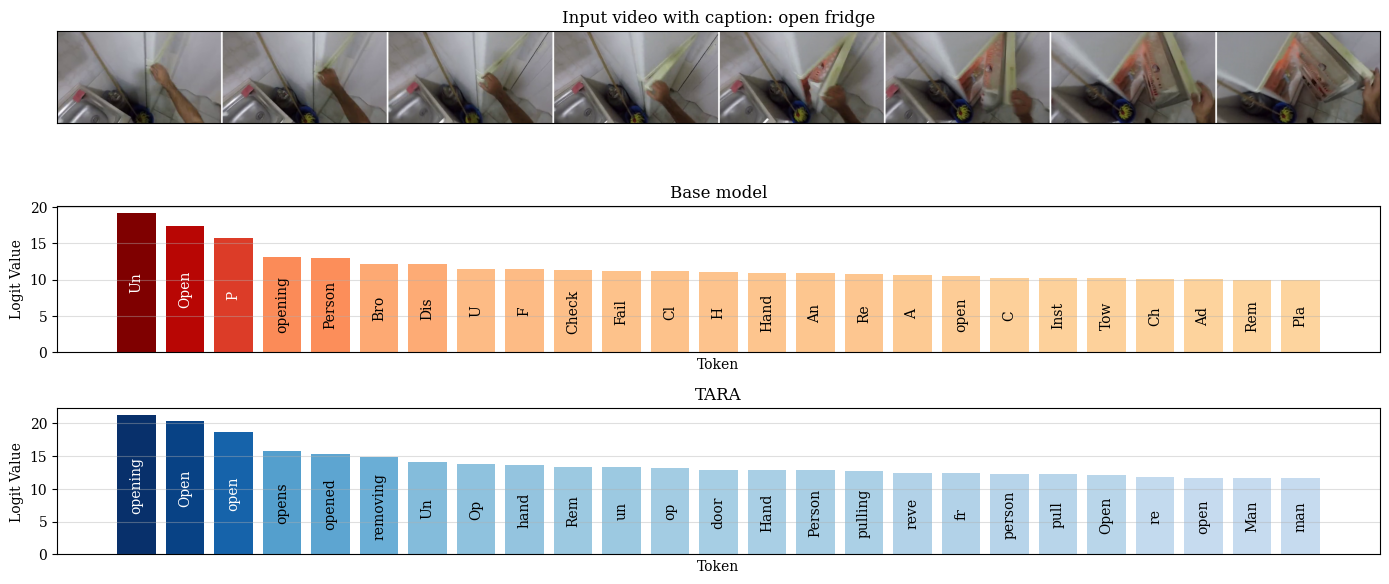

In [39]:
i = np.random.randint(len(df))
row = df.iloc[i].to_dict()
row

video_path = row['video_path']
frames_raw = read_frames_decord(video_path, 8)
tokens_base, logits_base = extract_topk_tokens(model_base, frames_raw)
tokens_fine, logits_fine = extract_topk_tokens(model_fine, frames_raw)

fig, axes = plt.subplots(3, 1, figsize=(14, 6))
canvas = su.visualize.concat_images_with_border(
    [PIL.Image.fromarray(f.numpy()) for f in frames_raw.permute((0, 2, 3, 1))]
)
ax = axes[0]
ax.imshow(canvas)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title("Input video with caption: %s" % row[label_col])

ax = axes[1]
plot_logits(tokens_base, logits_base, ax, cmap=plt.cm.OrRd)
ax.set_title("Base model")

ax = axes[2]
plot_logits(tokens_fine, logits_fine, ax, cmap=plt.cm.Blues)
ax.set_title("TARA")

plt.tight_layout()
plt.show()